# Hyperparameter Optimization Of TemporalFusionTransformer

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [2]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [3]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']
print(df_IT.shape)

(172, 13)


In [4]:
# Drop ACT04 column
df_IT = df_IT.drop(columns=['ACT04'])

In [5]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [6]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

target   ACT01  ACT03  ACT07  ACT09  ACT13   ACT15  \
item_id timestamp                                                        
IT01    2019-12-30  7613.0  1228.0   87.0  195.0  188.0   32.0  1817.0   
        2020-01-06   390.0    87.0   63.0    5.0    8.0    0.0     0.0   
        2020-01-13   702.0   161.0   10.0   14.0    0.0   49.0     1.0   
        2020-01-20   941.0   437.0  143.0   86.0   67.0  110.0     0.0   
        2020-01-27  1470.0   403.0  457.0  178.0  108.0   48.0     7.0   

                     ACT17   ACT32  ACT44  
item_id timestamp                          
IT01    2019-12-30  1255.0  2811.0    0.0  
        2020-01-06     0.0   227.0    0.0  
        2020-01-13     0.0   467.0    0.0  
        2020-01-20     0.0    98.0    0.0  
        2020-01-27     0.0   269.0    0.0

In [7]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

target  ACT01  ACT03  ACT07  ACT09  ACT13  ACT15  ACT17  \
item_id timestamp                                                             
IT01    2022-05-02  4074.0  788.0   29.0  396.0   30.0  111.0  515.0  145.0   
        2022-05-09   756.0  137.0    0.0  124.0    0.0    0.0    0.0    0.0   
        2022-05-16   439.0  153.0   27.0   76.0    2.0   24.0    0.0    0.0   
        2022-05-23  2078.0  452.0   28.0  387.0   57.0  158.0  506.0  138.0   
        2022-05-30  3883.0  912.0  198.0  514.0  178.0  261.0   14.0   10.0   

                     ACT32  ACT44  
item_id timestamp                  
IT01    2022-05-02  2060.0    0.0  
        2022-05-09   495.0    0.0  
        2022-05-16   157.0    0.0  
        2022-05-23   352.0    0.0  
        2022-05-30  1796.0    0.0

In [8]:
# Build predictor
predictor = TimeSeriesPredictor(
    prediction_length=12,
    freq='W-MON',
    target='target',
    path='C:\\Develop\\HPO\\TemporalFusionTransformer2',
    eval_metric='MASE'
)

In [9]:
from autogluon.common import space
from autogluon.common.utils.log_utils import add_log_to_file
from autogluon.timeseries.predictor import logger as LG

add_log_to_file("C:\\Develop\\HPO\\my.log", LG)

# Fit the model
predictor.fit(
    train_data,
    hyperparameters = {
        "TemporalFusionTransformer": { 
           "hidden_dim": 32,  
           "variable_dim": 128,
           "num_heads": 4,
           "dropout_rate": space.Categorical(0.1, 0.2, 0.3, 0.4, 0.5),
           "max_epochs": space.Categorical(100, 150, 200),
           "batch_size": 64,
           "lr": 0.01,
           "early_stopping_patience" : 10
        },
    },
    hyperparameter_tune_kwargs="auto",
    refit_full=True,
    num_val_windows=5,
    random_seed=42,
)

LG.info(
        predictor.leaderboard()
)

	Trained 10 models while tuning TemporalFusionTransformer.
	-0.4924       = Validation score (-MASE)
	10154.32 s    = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'TemporalFusionTransformer\\1fd58588': 0.11,
 'TemporalFusionTransformer\\50f07b04': 0.07,
 'TemporalFusionTransformer\\51d2f5e2': 0.15,
 'TemporalFusionTransformer\\6774d0d5': 0.59,
 'TemporalFusionTransformer\\daa48ead': 0.07}
	-0.4458       = Validation score (-MASE)
	5.80    s     = Training runtime
	0.27    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer\\521f698d', 'TemporalFusionTransformer\\01ee4816', 'TemporalFusionTransformer\\1fd58588', 'TemporalFusionTransformer\\6774d0d5', 'TemporalFusionTransformer\\50f07b04', 'TemporalFusionTransformer\\51d2f5e2', 'TemporalFusionTransformer\\05b65032', 'TemporalFusionTransformer\\cbfff631', 'TemporalFusionTransformer\\daa48ead', 'TemporalFusionTransformer\\8e9defd9', 'WeightedEnsemble']
Total runt

In [10]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  4305.291992  3867.474854  4015.437500  4137.951660   
        2022-05-09  1312.954468   879.330261  1040.792603  1181.614868   
        2022-05-16   384.211395    35.685654   155.342453   288.513824   
        2022-05-23  1366.767578  1031.512085  1161.250000  1294.218628   
        2022-05-30  4125.061035  3739.637207  3877.344971  3998.391113   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  4254.642090  4305.291992  4379.274414  4413.108887   
        2022-05-09  1283.333496  1312.954468  1386.355835  1422.780029   
        2022-05-16   361.640289   384.211395   458.462036   502.722076   
        2022-05-23  1344.259521  1366.767578  1429.947754  1463.209106   
        2022-05-30  4106.875000  4125.061035  4172.916016  4219.418457   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4536.662109  4726.483887  
        2022-05-09  1538.193481  1720.553467  
        2022-05-16   582.468811   731.764648  
        2022-05-23  1563.948730  1687.507202  
        2022-05-30  4297.101562  4431.296387

In [11]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble_FULL,-0.108039,NaN,0.311769,NaN,5.796612,22
1,WeightedEnsemble,-0.108039,-0.445797,0.302816,0.266395,5.796612,11
2,TemporalFusionTransformer\6774d0d5_FULL,-0.145122,NaN,0.056639,NaN,1768.984193,15
3,TemporalFusionTransformer\6774d0d5,-0.145122,-0.492351,0.054512,0.028136,7829.735518,4
4,TemporalFusionTransformer\1fd58588_FULL,-0.169063,NaN,0.064428,NaN,1214.613141,14
5,TemporalFusionTransformer\1fd58588,-0.169063,-0.535108,0.056484,0.039388,7462.380405,3
6,TemporalFusionTransformer\8e9defd9_FULL,-0.185009,NaN,0.077563,NaN,541.719119,21
7,TemporalFusionTransformer\8e9defd9,-0.185009,-0.554369,0.057601,0.018245,3268.269732,10
8,TemporalFusionTransformer\01ee4816_FULL,-0.186290,NaN,0.074529,NaN,1229.878255,13
9,TemporalFusionTransformer\01ee4816,-0.186290,-0.592387,0.061671,0.075858,7166.129652,2


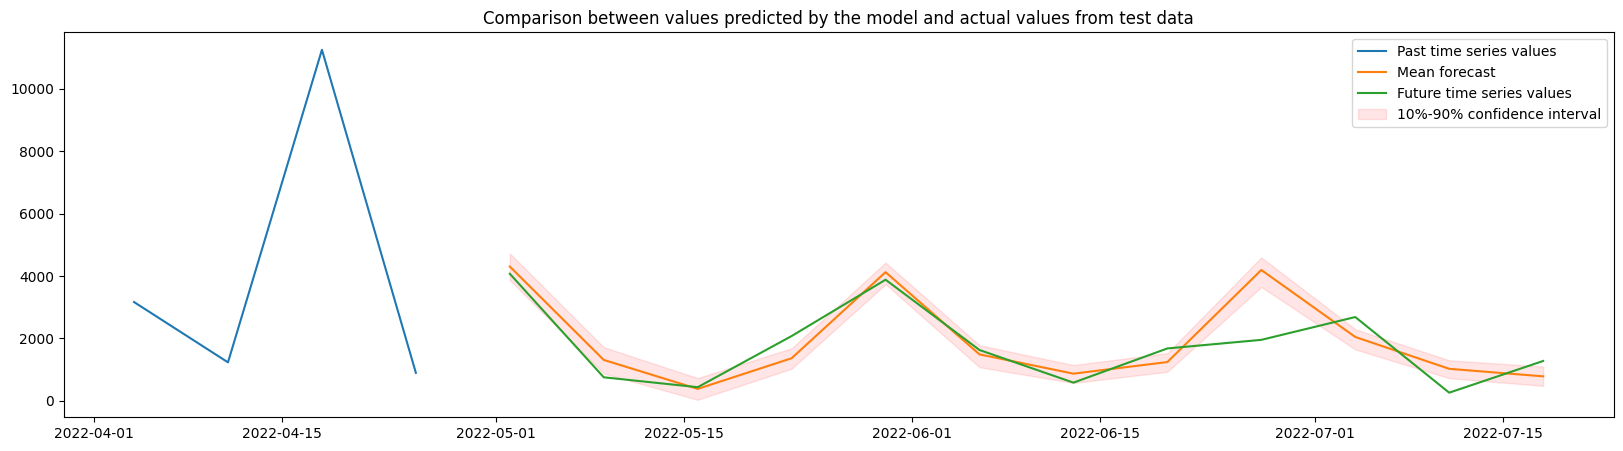

In [12]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data")

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

plt.plot(y_past[-4:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()

In [13]:
# Print all row of predictions where item_id is IT01
predictions.loc['IT01']

,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
timestamp,,,,,,,,,,
2022-05-02,4305.291992,3867.474854,4015.437500,4137.951660,4254.642090,4305.291992,4379.274414,4413.108887,4536.662109,4726.483887
2022-05-09,1312.954468,879.330261,1040.792603,1181.614868,1283.333496,1312.954468,1386.355835,1422.780029,1538.193481,1720.553467
2022-05-16,384.211395,35.685654,155.342453,288.513824,361.640289,384.211395,458.462036,502.722076,582.468811,731.764648
2022-05-23,1366.767578,1031.512085,1161.250000,1294.218628,1344.259521,1366.767578,1429.947754,1463.209106,1563.948730,1687.507202
2022-05-30,4125.061035,3739.637207,3877.344971,3998.391113,4106.875000,4125.061035,4172.916016,4219.418457,4297.101562,4431.296387
2022-06-06,1490.233154,1078.374756,1241.753662,1367.930542,1448.335571,1490.233154,1543.841187,1564.313477,1656.523438,1783.961548
2022-06-13,872.508789,574.093628,676.634888,792.886230,849.524658,872.508789,925.502563,943.210815,1027.139160,1148.201172
2022-06-20,1244.779419,934.176086,1041.313599,1162.334473,1225.186890,1244.779419,1303.131348,1328.772095,1419.269775,1530.968872
2022-06-27,4194.273926,3651.285645,3857.499756,4010.912842,4152.664551,4194.273926,4289.199219,4278.437500,4447.260742,4597.243652


In [14]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

23159.193

In [15]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [16]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02     231.291992
2022-05-09     556.954468
2022-05-16     -54.788605
2022-05-23    -711.232422
2022-05-30     242.061035
2022-06-06    -139.766846
2022-06-13     287.508789
2022-06-20    -436.220581
2022-06-27    2238.273926
2022-07-04    -638.471680
2022-07-11     764.752075
2022-07-18    -492.167175
dtype: float64

In [17]:
# Show model names
predictor.model_names() # aa0c2617 non usato per ensamble

['TemporalFusionTransformer\\521f698d',
 'TemporalFusionTransformer\\01ee4816',
 'TemporalFusionTransformer\\1fd58588',
 'TemporalFusionTransformer\\6774d0d5',
 'TemporalFusionTransformer\\50f07b04',
 'TemporalFusionTransformer\\51d2f5e2',
 'TemporalFusionTransformer\\05b65032',
 'TemporalFusionTransformer\\cbfff631',
 'TemporalFusionTransformer\\daa48ead',
 'TemporalFusionTransformer\\8e9defd9',
 'WeightedEnsemble',
 'TemporalFusionTransformer\\521f698d_FULL',
 'TemporalFusionTransformer\\01ee4816_FULL',
 'TemporalFusionTransformer\\1fd58588_FULL',
 'TemporalFusionTransformer\\6774d0d5_FULL',
 'TemporalFusionTransformer\\50f07b04_FULL',
 'TemporalFusionTransformer\\51d2f5e2_FULL',
 'TemporalFusionTransformer\\05b65032_FULL',
 'TemporalFusionTransformer\\cbfff631_FULL',
 'TemporalFusionTransformer\\daa48ead_FULL',
 'TemporalFusionTransformer\\8e9defd9_FULL',
 'WeightedEnsemble_FULL']

In [19]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\1fd58588")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.2,
 'max_epochs': 200,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [20]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\50f07b04")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.4,
 'max_epochs': 150,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [21]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\51d2f5e2")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.3,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [22]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\6774d0d5")  # provide the model name here 
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.2,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [23]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\daa48ead")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.4,
 'max_epochs': 150,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}